# Building pretty maps

## Data Load

In [22]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import folium
import selenium
from PIL import Image
import io

### load in data centre file

In [2]:
DCFile = './Data/Output_files/Spreadsheets/outfile.xlsx'
df_dc = pd.read_excel(DCFile)
df_dc.head()

,Unnamed: 0,Country,Total Land Area,Total Build Area,Total Available Land,Total Annual Power Consumption,Land Requirement for Solar,Site,Latitude,Longitude,std,mean,vari_score,PV,Expected Total Land Required,Excess Land Required,Land Price (R per Ha),Total Land Price (R),Land Use Preference
0,0,South Africa,6379.00,929.0,5450.0,3412020.0,7081.818182,Berea Switch,E31 00.381,S29 51.443,5.338546,124.751411,0.042793,1467,11629.243354,6179.243354,6212.595318,7.224778e+07,0.0
1,3,South Africa,1390.00,1344.0,46.0,2504922.0,5199.090909,Bloemfontein Switch,E26 13.174,S29 06.934,8.506760,157.255829,0.054095,1867,6708.414569,6662.414569,3097.995046,2.078264e+07,0.0
2,6,South Africa,790.00,790.0,0.0,1489638.0,3091.818182,Cape Town Switch,E18 25.321,S33 55.810,34.628254,145.681747,0.237698,1688,4412.434834,4412.434834,5120.483718,2.259380e+07,0.0
3,9,South Africa,14856.00,3455.0,11401.0,6324720.0,13127.272727,Centurion,E28 10.206,S25 54.584,10.737539,151.091507,0.071066,1782,17746.127946,6345.127946,13106.048683,2.325816e+08,0.0
4,12,South Africa,5370.41,3934.0,0.0,12483000.0,25909.090909,Doornfontein,E28 03.333,S26 11.783,12.330755,149.564499,0.082444,1765,35362.606232,35362.606232,13140.323843,4.646761e+08,0.4


Great, there's our base data. It's much too rich, we just want names, cost and locations for now

### Strip down data centre file to essentials

In [3]:
keep_cols = ['Site', 'Longitude', 'Latitude', 'Total Land Price (R)']
df = df_dc[keep_cols]
df.head()

,Site,Longitude,Latitude,Total Land Price (R)
0,Berea Switch,S29 51.443,E31 00.381,7.224778e+07
1,Bloemfontein Switch,S29 06.934,E26 13.174,2.078264e+07
2,Cape Town Switch,S33 55.810,E18 25.321,2.259380e+07
3,Centurion,S25 54.584,E28 10.206,2.325816e+08
4,Doornfontein,S26 11.783,E28 03.333,4.646761e+08


### get geopandas world map

In [4]:
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

In [5]:
city_data = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

C:\Users\hurwi\AppData\Local\Temp\ipykernel_4832\3187775905.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_cities' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  city_data = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))


In [6]:
world_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

C:\Users\hurwi\AppData\Local\Temp\ipykernel_4832\3432786234.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [7]:
type(city_data)

geopandas.geodataframe.GeoDataFrame

<Axes: >

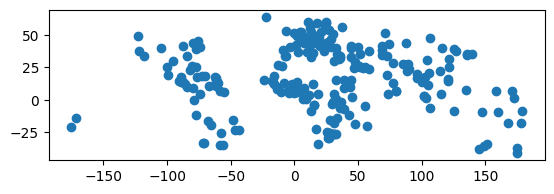

In [8]:
city_data.plot()

<Axes: >

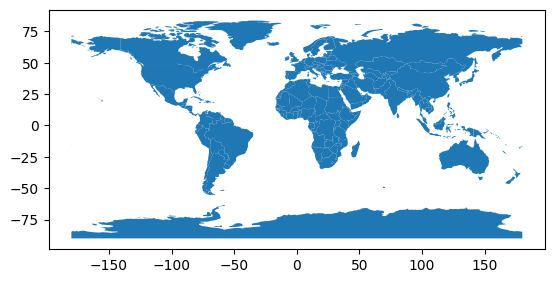

In [9]:
world_data.plot()

OK, so those are basic country plots. not quite so detailed as I'd like

## Explore naturalearth maps

In [10]:
world_data.columns

Index(['pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est', 'geometry'], dtype='object')

In [11]:
world_data.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [12]:
SAName = [N for N in world_data.name.unique() if 'Africa' in N]
SAName

['South Africa', 'Central African Rep.']

<Axes: >

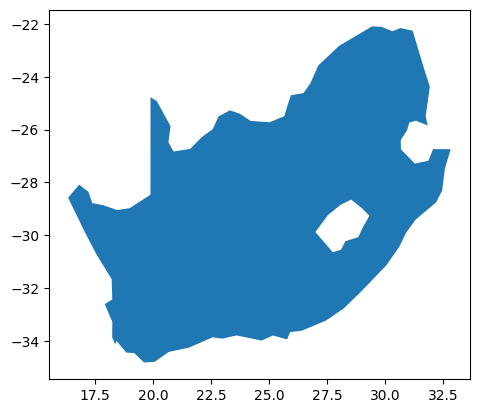

In [13]:
world_data[world_data.name == SAName[0]].plot()

OK, there are slightly more detailed maps in naturalearth, but honestly they're not great...<br>
let's see how good / bad using the google api is

## Google api

### basic map

In [16]:
map = folium.Map(location=[21.39, 84.29], zoom_start = 13)
map

OK, that's pretty neat! <br>
<br>
let's see if we can find a location from our dataset

### save map to file

In [25]:
TEST_MAP_FILE = './WorkingData/Maps/testgooglemap.png'

In [24]:
img_data = map._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save(TEST_MAP_FILE)

![test file](WorkingData/Maps/testgooglemap.png)

Well that's great!

### Our data points?

lets get the map of RSA

In [32]:
df.head()

,Site,Longitude,Latitude,Total Land Price (R)
0,Berea Switch,S29 51.443,E31 00.381,7.224778e+07
1,Bloemfontein Switch,S29 06.934,E26 13.174,2.078264e+07
2,Cape Town Switch,S33 55.810,E18 25.321,2.259380e+07
3,Centurion,S25 54.584,E28 10.206,2.325816e+08
4,Doornfontein,S26 11.783,E28 03.333,4.646761e+08


In [34]:
point = [df.iloc[0, 1], df.iloc[0, 2]]
point

['S29 51.443', 'E31 00.381']

In [80]:
point2 = [df.iloc[1, 1], df.iloc[1, 2]]
label2 = df.iloc[1,0]
point2

['S29 06.934', 'E26 13.174']

#### Base SA map

In [88]:
my_map = folium.Map(location=[-29, 25], zoom_start=6)
my_map

#### create points / markers

In [89]:
def convert_to_coordinates (in_str: str):

    compass = in_str[0]
    if compass in ['W', 'S']:
        negative = True
    else:
        negative = False
    S = in_str[1:]
    S_deg, S_min = S.split(' ')
    deg = float(S_deg)
    min = float(S_min)
    if negative:
        deg *= -1
        min *= -1

    result = deg + min/60
    
    return result

In [90]:
def to_coords (string_point):

    out = [convert_to_coordinates(point) for point in string_point]
    return out

In [91]:
to_coords(point)

[-29.857383333333335, 31.00635]

In [92]:
folium.Marker(to_coords(point), popup = 'Berea Switch').add_to(my_map)
my_map

alternatively, a circle marker

In [96]:
folium.CircleMarker(to_coords(point2), color='pink', fill=True).add_to(my_map)
folium.Marker(to_coords(point2), 
              popup = label2,
              icon=folium.DivIcon(html='<div style="font-size: 12pt">%s</div>' % label2)).add_to(my_map)
my_map

OK, I can do this!

#### Zoomed in views

In [97]:
subset_df = df.head(5)

In [98]:
subset_df

,Site,Longitude,Latitude,Total Land Price (R)
0,Berea Switch,S29 51.443,E31 00.381,7.224778e+07
1,Bloemfontein Switch,S29 06.934,E26 13.174,2.078264e+07
2,Cape Town Switch,S33 55.810,E18 25.321,2.259380e+07
3,Centurion,S25 54.584,E28 10.206,2.325816e+08
4,Doornfontein,S26 11.783,E28 03.333,4.646761e+08


In [104]:
subset_df['coords'] = subset_df.apply(lambda x: to_coords([x['Longitude'], x['Latitude']]), axis=1)
subset_df

C:\Users\hurwi\AppData\Local\Temp\ipykernel_4832\2721418478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['coords'] = subset_df.apply(lambda x: to_coords([x['Longitude'], x['Latitude']]), axis=1)


,Site,Longitude,Latitude,Total Land Price (R),coords
0,Berea Switch,S29 51.443,E31 00.381,7.224778e+07,"[-29.857383333333335, 31.00635]"
1,Bloemfontein Switch,S29 06.934,E26 13.174,2.078264e+07,"[-29.115566666666666, 26.219566666666665]"
2,Cape Town Switch,S33 55.810,E18 25.321,2.259380e+07,"[-33.930166666666665, 18.422016666666668]"
3,Centurion,S25 54.584,E28 10.206,2.325816e+08,"[-25.90973333333333, 28.1701]"
4,Doornfontein,S26 11.783,E28 03.333,4.646761e+08,"[-26.196383333333333, 28.05555]"


In [129]:
maps = [folium.Map(location=coords, zoom_start=13) for coords in subset_df.coords.values]

In [130]:
folium.CircleMarker(location=list(subset_df.coords.values)[0],
                    radius = 6,
                    color = 'Blue',
                    fill=True).add_to(maps[0])
folium.Marker(list(subset_df.coords.values)[0], 
              popup = subset_df.Site[0],
              icon=folium.DivIcon(html='<div style="font-size: 12pt">%s</div>' % subset_df.Site[0])).add_to(maps[0])
maps[0]

In [131]:
maps[0].save('bunny.html')